Victor CHAU & Tahar AMAIRI
# IFT 870 - Forage de données
## TP4 : Fonctions descriptives

### Sommaire
- 1. Segmentation des données suivant la longueur des séquences
    - a) Histogramme
    - b) Partitionnement
- 2. Partitionnement à partir d’une représentation vectorielle des données
    - a) Représentation vectorielle
    - b) Suppression des motifs non-fréquents
    - c) Choix du nombre de clusters pour chaque groupe
- 3. Partitionnement à partir d’une matrice de distances
    - a) Construction de la matrice de distance
    - b) K-Medoids
    - c) Choix du nombre de clusters pour chaque groupe
- 4. Analyse de la signification sémantique
    - a) K-Means
    - b) K-Medoids
    - c) Comparaison entre les deux méthodes
     
## Importation des données

In [ ]:
# import libs
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import display
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from Bio import pairwise2
import pandas as pd
import numpy as np

In [2]:
# read CSV
df = pd.read_csv('TP4_data.csv')

# print the df
df.head()

,id,sequence
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...


## 1. Segmentation des données suivant la longueur des séquences
### a) Histogramme

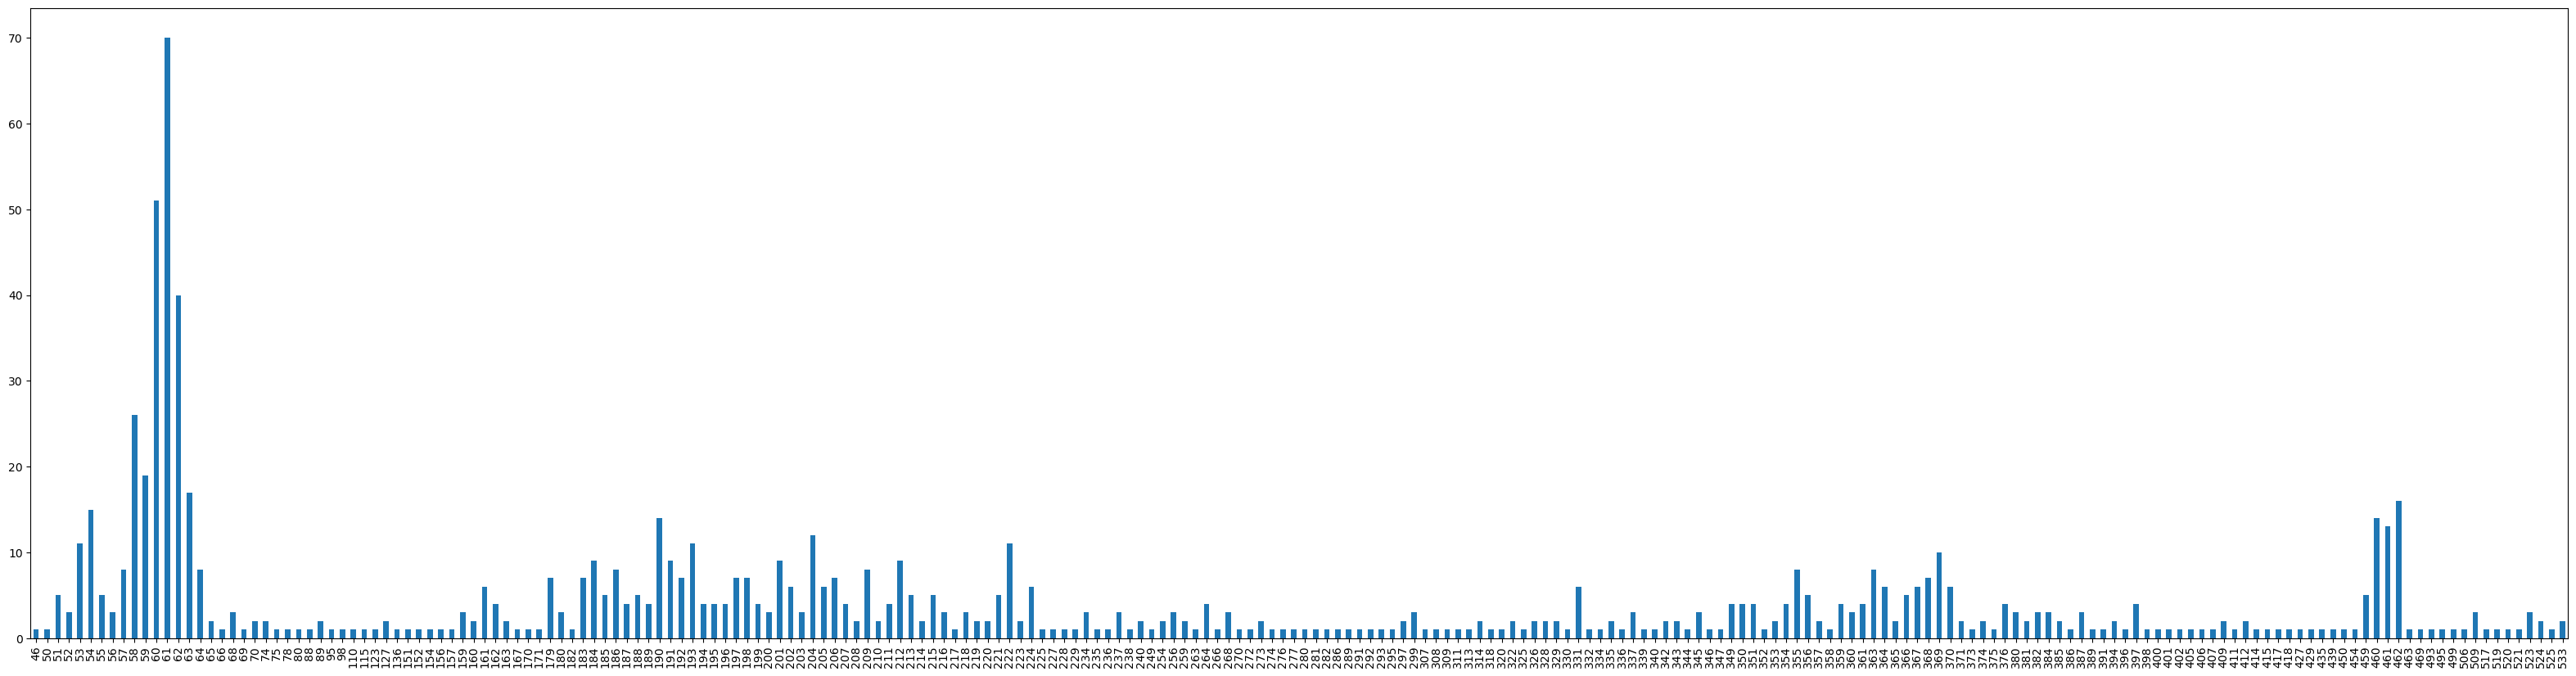

In [3]:
# plot histogram
freq = df['sequence'].str.len().value_counts()
freq = freq.loc[np.sort(freq.index)]
freq.plot(kind='bar', figsize=(40,10));

### b) Partitionnement 
Nous avons découpé les données en groupe ayant des longueurs similaires car on observe une distribution des longueurs de séquences qui présente plusieurs pics (comme une gaussienne). Le découpage se fera donc selon la concentration d’occurrence des longueurs. On peut justifier ce découpage des données en se basant sur l'idée que les séquences d'ARN-nc qui ont des longueurs similaires ont peut-être des caractéristiques communes. En effet, il est possible que les ARN-nc qui ont une longueur proche partagent des motifs ou des structures similaires qui sont importants pour leur fonctionnement. Ainsi, en découpant les données en groupes selon les distributions de longueurs, on peut potentiellement mettre en évidence ses caractéristiques communes et mieux comprendre les relations entre les séquences d'ARN-nc dans ces groupes.

Par conséquent, le partitionnement se fera comme ceci :
- Groupe 1 : longueur $< 124$.
- Groupe 2 : longueur dans $[127,300[$
- Groupe 3 : longueur dans $[300,410[$
- Groupe 4 : longueur $\geq 410$

In [4]:
# first group
mask = (df['sequence'].str.len() < 124)
df1 = df.loc[mask,:]

# second group
mask = (df['sequence'].str.len() >= 127) & (df['sequence'].str.len() < 300)
df2 = df.loc[mask,:]

# third group
mask = (df['sequence'].str.len() >= 300) & (df['sequence'].str.len() < 410)
df3 = df.loc[mask,:]

# fourth group
mask = (df['sequence'].str.len() >= 410)
df4 = df.loc[mask,:]

## 2. Partitionnement à partir d’une représentation vectorielle des données
### a) Représentation vectorielle

In [5]:
# transform a list of sequences into a k-mer vectorial representation using a list of k-mer
def SeqToKMerVec(seq, k_mer):
    # data frame containing the results
    df = pd.DataFrame(0, index=np.arange(len(seq)), columns=["{}-mer".format(k) for k in k_mer])

    # iterate over each k-mer value 
    for k in k_mer:
        # transform into a k-mer vectorial representation
        df['{}-mer'.format(k)] = seq.apply(lambda s: [s[i:i+k] for i in range(len(s)-k+1)]).values

    # return the df
    return df

# first group
dfKMerVec1 = SeqToKMerVec(df1['sequence'], [2,3,4])

# print the result
dfKMerVec1.head()

,2-mer,3-mer,4-mer
0,"[UU, UU, UC, CG, GU, UU, UC, CA, AC, CC, CC, C...","[UUU, UUC, UCG, CGU, GUU, UUC, UCA, CAC, ACC, ...","[UUUC, UUCG, UCGU, CGUU, GUUC, UUCA, UCAC, CAC..."
1,"[AU, UU, UC, CG, GU, UU, UC, CA, AC, CC, CC, C...","[AUU, UUC, UCG, CGU, GUU, UUC, UCA, CAC, ACC, ...","[AUUC, UUCG, UCGU, CGUU, GUUC, UUCA, UCAC, CAC..."
2,"[AA, AU, UC, CG, GA, AG, GA, AG, GG, GA, AA, A...","[AAU, AUC, UCG, CGA, GAG, AGA, GAG, AGG, GGA, ...","[AAUC, AUCG, UCGA, CGAG, GAGA, AGAG, GAGG, AGG..."
3,"[CC, CC, CU, UU, UG, GA, AG, GU, UA, AG, GA, A...","[CCC, CCU, CUU, UUG, UGA, GAG, AGU, GUA, UAG, ...","[CCCU, CCUU, CUUG, UUGA, UGAG, GAGU, AGUA, GUA..."
4,"[UU, UA, AA, AA, AC, CG, GA, AG, GG, GA, AU, U...","[UUA, UAA, AAA, AAC, ACG, CGA, GAG, AGG, GGA, ...","[UUAA, UAAA, AAAC, AACG, ACGA, CGAG, GAGG, AGG..."


In [6]:
# do the same for the other groups
dfKMerVec2 = SeqToKMerVec(df2['sequence'], [2,3,4])
dfKMerVec3 = SeqToKMerVec(df3['sequence'], [2,3,4])
dfKMerVec4 = SeqToKMerVec(df4['sequence'], [2,3,4])

### b) Suppression des motifs non-fréquents
Il est important de retirer les motifs les moins fréquents de la représentation car ils ne sont pas suffisamment représentatifs des séquences et n'apportent pas d'informations significatives. De plus, leur présence peut ajouter du bruit à la représentation et affecter négativement les résultats de la classification. En éliminant les motifs les moins fréquents, on obtient une représentation plus efficace et pertinente des séquences, ce qui peut améliorer la qualité de la classification. Sans oublier, qu'en prenant en compte tous les motifs, on risque d'avoir une matrice des données très grande pouvant étendre le temps d'exécution.  

In [7]:
# remove non frequent motif from a list of sequence using a threshold 
def removeNonFrequentMotif(seq, threshold):
    # get all the motifs
    motifs = set(seq.sum())
    # number of sequences in seq
    n = len(seq)
   
    # filter each motif
    for motif in motifs:
        # occurrence of the motif
        count = 0

        # compute the occurrence
        for l in seq.values:
            if motif in l:
                count += 1

        # if the score is less than the threshold, remove the motif
        if count / n < threshold:
            for i in range(n):
                seq.values[i] = [j for j in seq.values[i] if j != motif]

# transform the vectorial representation to a matrix
def KMerVecToMatrix(dfKMerVec, threshold):
    # the matrix containing the result 
    m = pd.DataFrame()

    for col in dfKMerVec:
        # first remove non frequent motifs
        removeNonFrequentMotif(dfKMerVec[col], threshold)
        # get the matrix for the current k-mer
        dum = pd.get_dummies(dfKMerVec[col].explode()).groupby(level=0).sum()
        # concatenate to m
        m = pd.concat([m,dum], axis=1)

    return m

# first group
m1 = KMerVecToMatrix(dfKMerVec1, 1/3)

# print the result
m1.head()

,AA,AC,AG,AU,CA,CC,CG,CU,GA,GC,...,GCAA,GCCG,GGAA,GUUC,UCGG,UGCA,UGCU,UUCA,UUGA,UUGC
0,2,3,3,4,5,3,4,1,4,3,...,0,0,1,2,0,0,0,1,1,0
1,2,3,4,5,3,4,4,2,3,4,...,0,0,1,1,0,0,0,1,0,0
2,17,2,4,5,2,1,2,3,6,3,...,1,0,1,0,0,1,1,0,1,1
3,3,2,6,1,5,8,4,3,3,7,...,0,0,1,1,0,0,1,1,1,2
4,10,2,5,4,2,1,2,5,4,4,...,1,0,0,0,0,1,1,0,0,1


In [8]:
# do the same for the other groups
m2 = KMerVecToMatrix(dfKMerVec2, 1/3)
m3 = KMerVecToMatrix(dfKMerVec3, 1/3)
m4 = KMerVecToMatrix(dfKMerVec4, 1/3)

### c) Choix du nombre de clusters pour chaque groupe

In [9]:
# plot silhouette score, adapted from : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def plotSilhouetteScore(range_n_clusters, X, KMethod, KMethodParam, metric, sklearn = False):
    nPlots = len(range_n_clusters)  # number of plots
    nRows = int(np.ceil(nPlots / 3))  # number of rows for the subplots

    # create subplot
    fig, ax = plt.subplots(nrows=nRows, ncols=3, figsize=(15, 10))
    fig.tight_layout(pad=3.5)
    ax = ax.flatten()

    for i in range(nPlots):
        # get subplot and the number of clusters
        ax1 = ax[i]
        n_clusters = range_n_clusters[i]
       
        # The silhouette coefficient can range from -1 to 1
        ax1.set_xlim([-1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # get labels from the specified KMethod
        if sklearn:
            cluster_labels = KMethod(n_clusters = n_clusters, **KMethodParam).fit(X).labels_
        else:
            cluster_labels = KMethod(n_clusters = n_clusters, **KMethodParam)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels, metric=metric)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels, metric=metric)
        y_lower = 10

        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Number of clusters = {}, silhouette score = {:.3f}".format(n_clusters, silhouette_avg))
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-1, -0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # remove unnecessary plot
    toRemove = (nRows * 3) - nPlots
    for i in range(toRemove):
        ax.flat[(nRows * 3) - 1 - i].set_visible(False)

In [10]:
# k values to test
range_n_clusters = list(range(2,11))
# KMeans param
param = {'n_init' : 10, 'max_iter' : 1000, 'random_state' : 0}

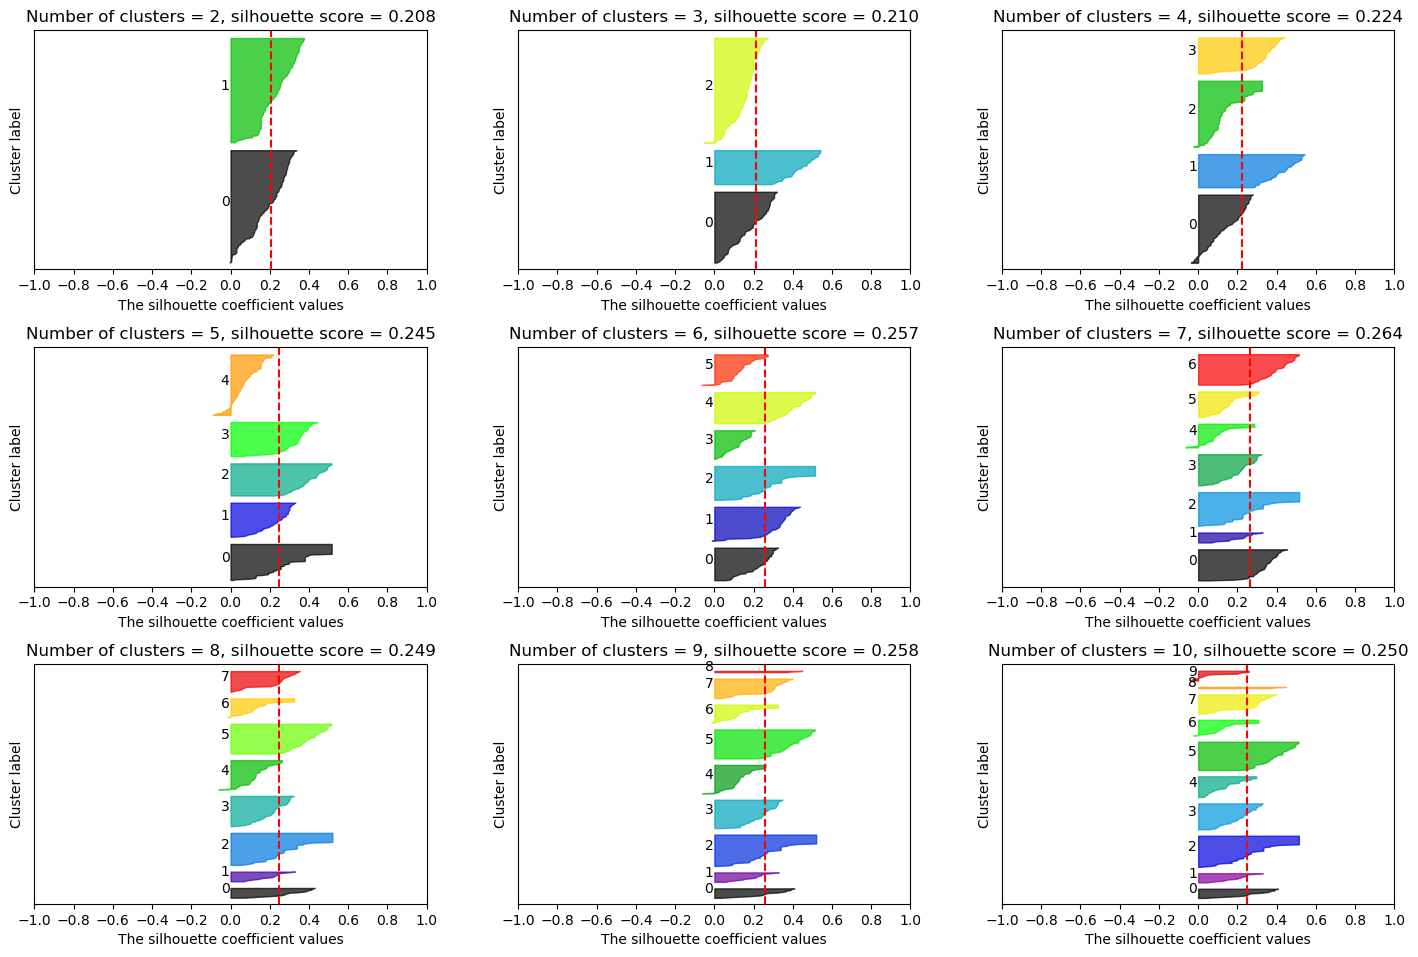

In [11]:
# first group
plotSilhouetteScore(range_n_clusters, m1.to_numpy(), KMeans, param, "euclidean", sklearn=True)

Pour le groupe 1, le graphique de silhouette suggère que le nombre optimal de clusters serait de 6. On obtient un score moyen de 0.257 qui est un des meilleurs. Presque tous les clusters ont un score de silhouette supérieur à la moyenne, et les tailles de cluster sont cohérentes.  On peut aussi envisager 4 ou 5 clusters car ils ont de bons scores cependant les tailles des clusters sont moins uniformes.

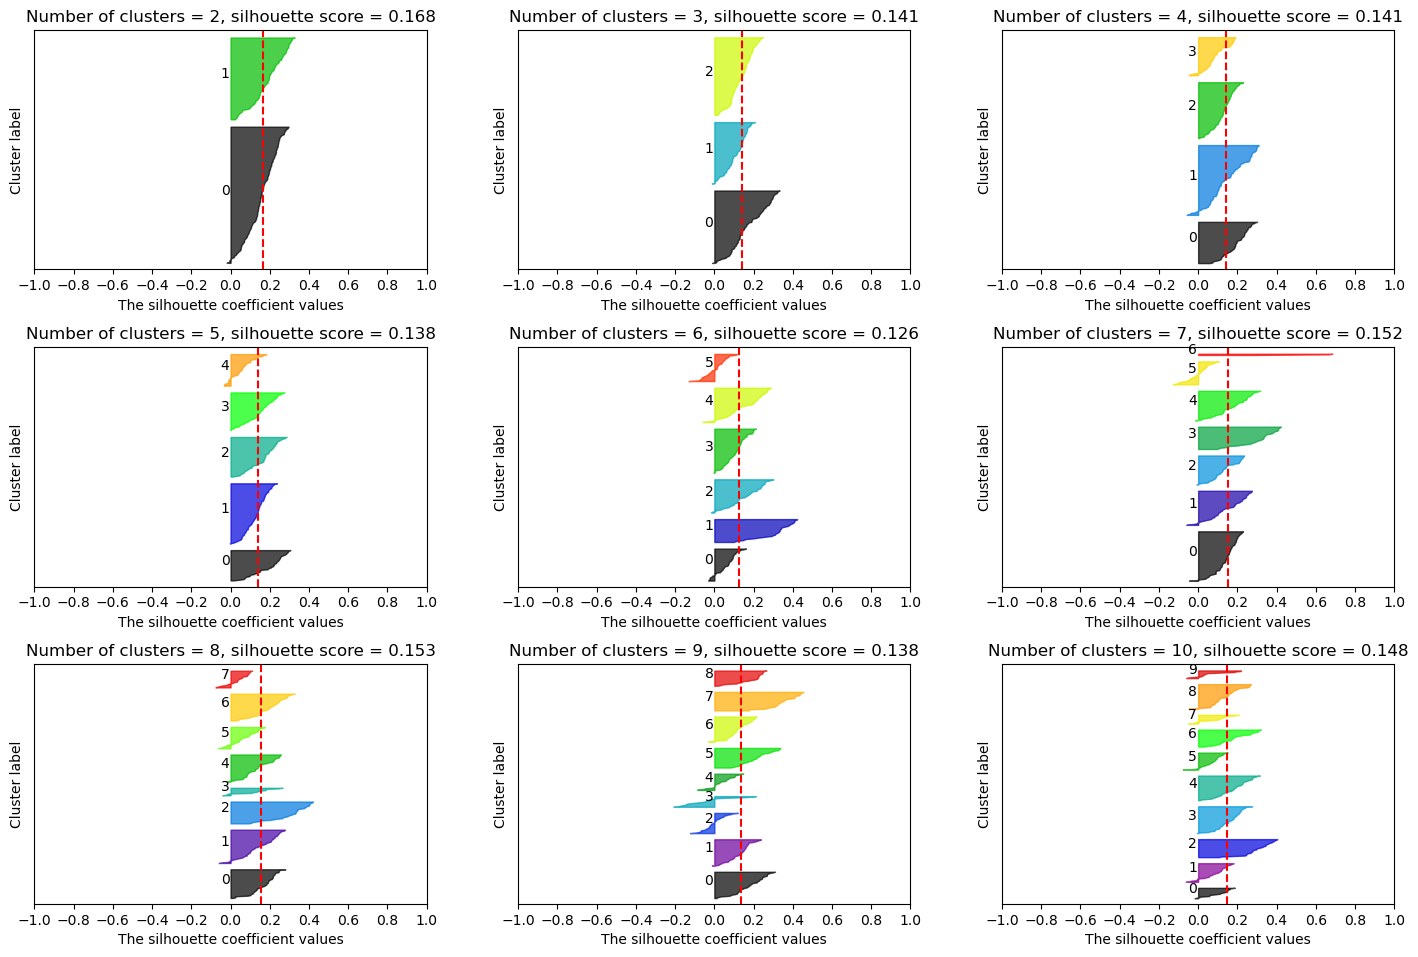

In [12]:
# second group
plotSilhouetteScore(range_n_clusters, m2.to_numpy(), KMeans, param, "euclidean", sklearn=True)

Pour le groupe 2, le graphique de silhouette suggère que le nombre optimal de clusters serait de 3. On obtient un score moyen de 0.141 qui est bon par rapport aux autres. Tous les clusters ont un score de silhouette supérieur à la moyenne, même s'il y a des fluctuations dans la taille des clusters. Par ailleurs, 4 clusters pourraient aussi être un nombre de clusters envisageable.

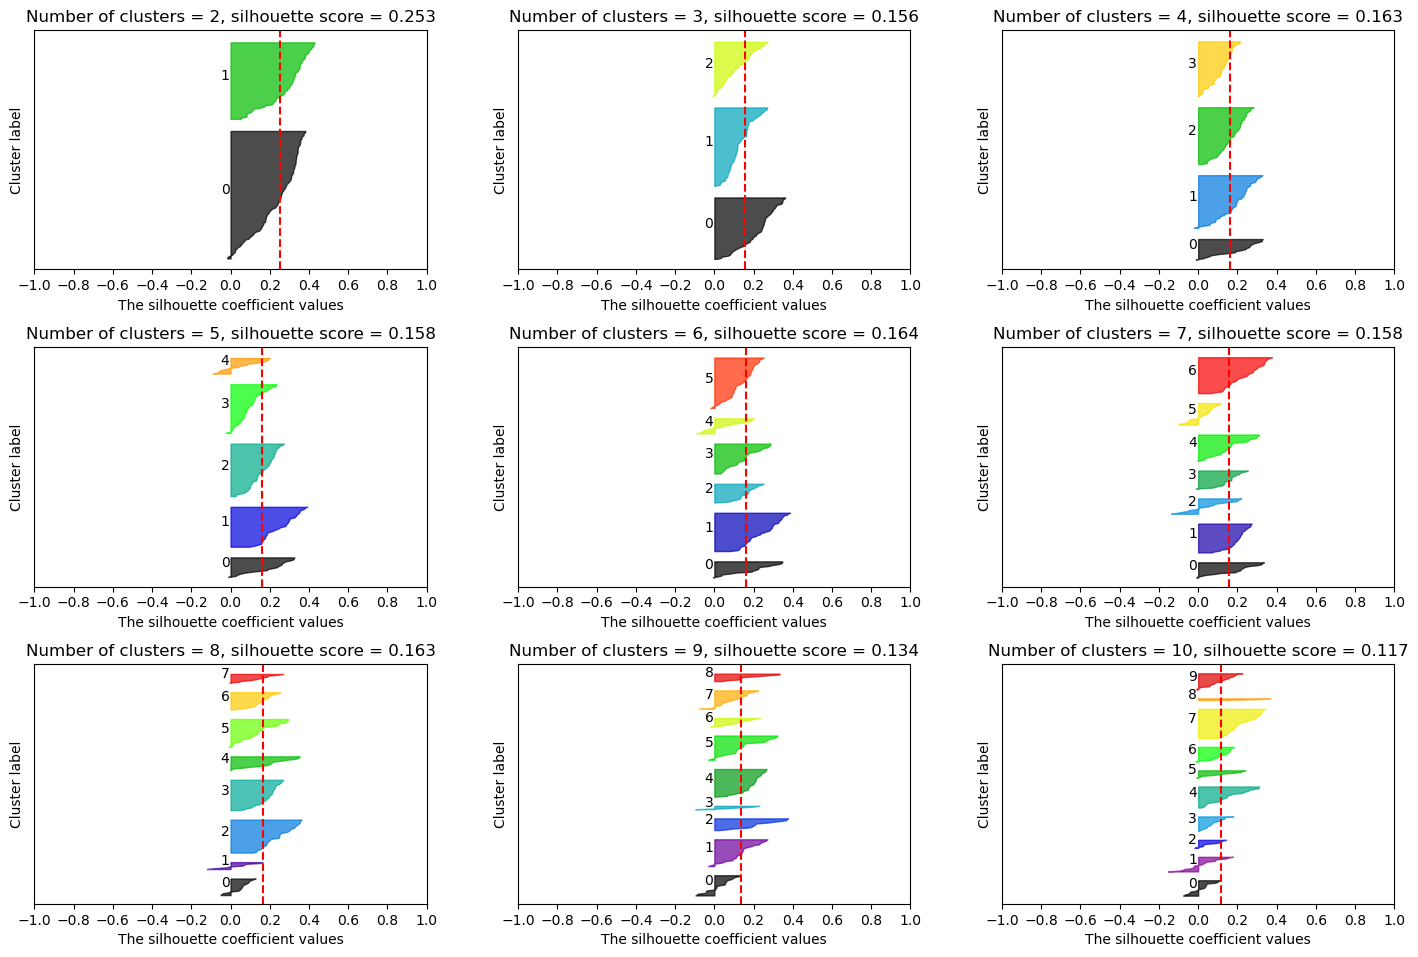

In [13]:
# third group
plotSilhouetteScore(range_n_clusters, m3.to_numpy(), KMeans, param, "euclidean", sklearn=True)

Pour le groupe 3, le graphique de silhouette suggère que le nombre optimal de clusters serait de 2. On obtient un score moyen de 0.253 qui est meilleur que les autres. Tous les clusters ont un score de silhouette supérieur à la moyenne, et il n'y a pas beaucoup de fluctuations dans la taille des clusters.

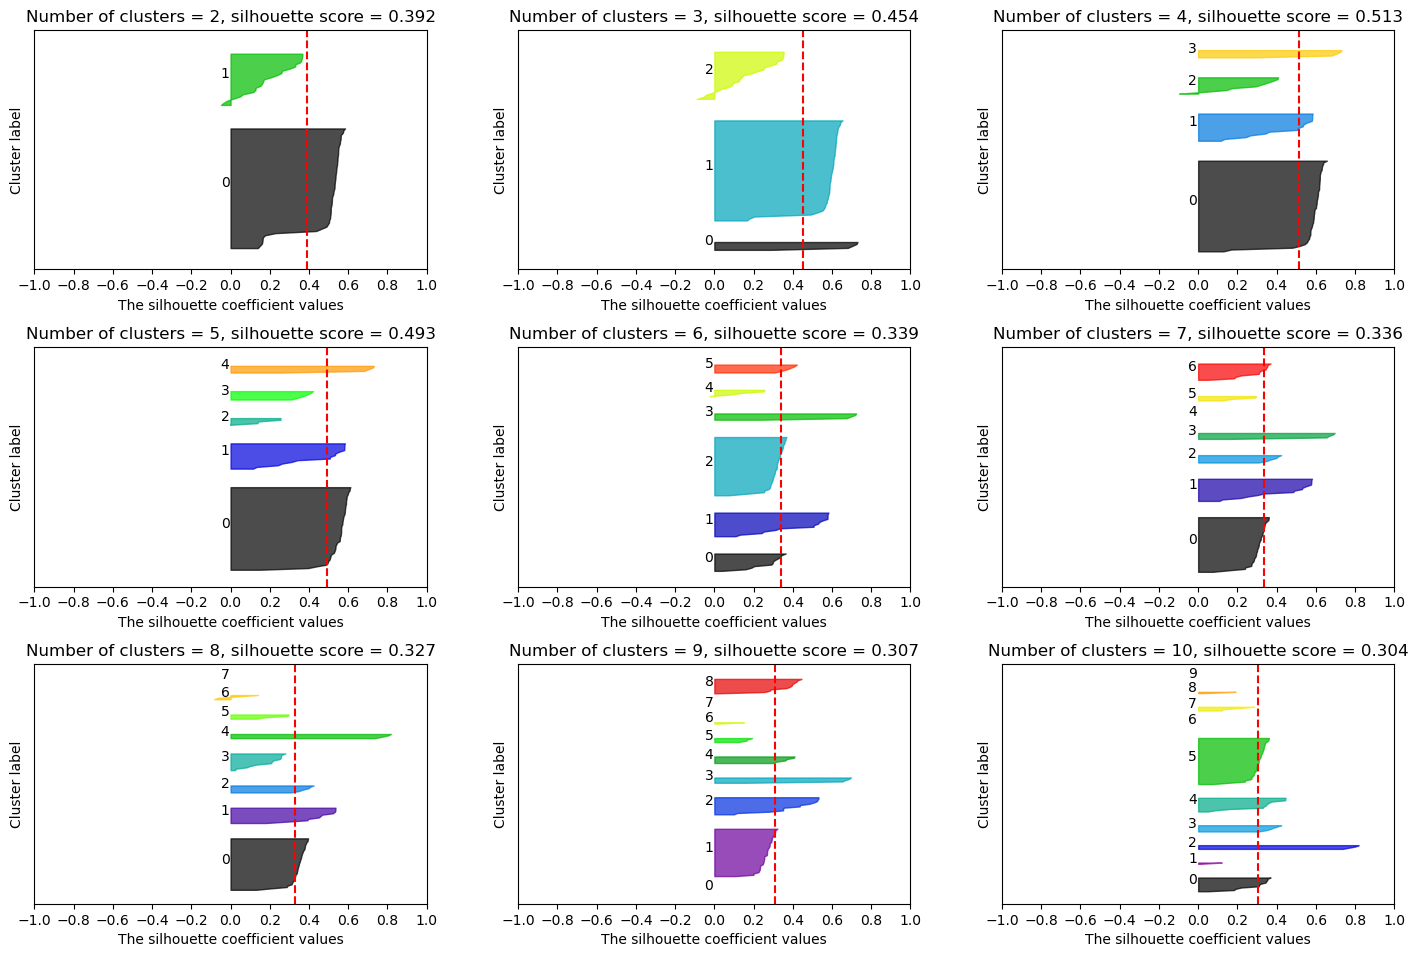

In [14]:
# fourth group
plotSilhouetteScore(range_n_clusters, m4.to_numpy(), KMeans, param, "euclidean", sklearn=True)

Pour le groupe 4, la distribution des tailles des clusters est très mauvaise pour chaque $k$ (nombre de cluster). Par conséquent, on prendra 4 comme choix car c'est celui qui a le meilleur score moyen. 

Par conséquent, le nombre de clusters pour chaque groupe est :

- Groupe 1 : 6
- Groupe 2 : 3
- Groupe 3 : 2
- Groupe 4 : 4

## 3. Partitionnement à partir d’une matrice de distances
### a) Construction de la matrice de distance

In [15]:
# compute the alignement between two sequences
def dist(S1, S2):
    alignment = pairwise2.align.globalxx(S1,S2)
    return alignment[0][4] - alignment[0][2]

# get the matrix of distance of a list of sequences
def getDistMatrix(seq):
    # number of sequences
    n = len(seq)
    # data frame containing the results
    df = pd.DataFrame(0.0, index=np.arange(n), columns=np.arange(n))

    # iterate over each sequence
    for i in range(n):
        S1 = seq.values[i]
        for j in range(i,n):
            df.iloc[i,j] = df.iloc[j,i] = dist(S1,seq.values[j])
  
    # return the df
    return df

# first group
dfDist1 = getDistMatrix(df1['sequence'])

# print the result
dfDist1.head()

,0,1,2,3,4,5,6,7,8,9,...,295,296,297,298,299,300,301,302,303,304
0,0.0,11.0,59.0,54.0,50.0,46.0,46.0,35.0,54.0,50.0,...,47.0,47.0,50.0,50.0,52.0,47.0,56.0,54.0,2.0,50.0
1,11.0,0.0,56.0,51.0,47.0,45.0,43.0,34.0,51.0,47.0,...,46.0,44.0,45.0,45.0,49.0,48.0,55.0,55.0,13.0,45.0
2,59.0,56.0,0.0,55.0,25.0,49.0,53.0,54.0,31.0,47.0,...,60.0,44.0,45.0,45.0,57.0,48.0,67.0,17.0,59.0,45.0
3,54.0,51.0,55.0,0.0,54.0,50.0,46.0,55.0,56.0,46.0,...,55.0,47.0,48.0,48.0,30.0,47.0,44.0,50.0,54.0,48.0
4,50.0,47.0,25.0,54.0,0.0,42.0,52.0,45.0,36.0,44.0,...,55.0,41.0,44.0,44.0,56.0,47.0,64.0,20.0,50.0,44.0


In [16]:
# do the same for the other groups
dfDist2 = getDistMatrix(df2['sequence'])
dfDist3 = getDistMatrix(df3['sequence'])
dfDist4 = getDistMatrix(df4['sequence'])

### b) K-Medoids

In [17]:
# k-medoids clustering
def KMedoid(n_clusters, X):
    # number of sequences
    n = X.shape[0]
    # check if n_clusters is less or equal to the size of X
    n_clusters = n_clusters if n_clusters <= n else n
    # pick the n_clusters points with the smallest sum distance to every other point
    medoids, prevMedoids = np.argpartition(np.sum(X, axis=1), n_clusters - 1)[:n_clusters], np.zeros(n_clusters)
    
    # loop until the medoids do not change
    while(not (medoids == prevMedoids).all()):
        # get the cluster idx for each sequences
        clusterIdx = np.argmin(X[:,medoids], axis=1)
        # cache medoids
        prevMedoids = medoids.copy()
        
        # update each medoids
        for k in range(n_clusters):
            # get sequences of the cluster k
            t = clusterIdx == k
            # get the indexes
            idx = t.nonzero()[0]

            # check if the cluster is not empty
            if len(idx) == 0:
                continue

            # to store the distance mean of each sequences of the cluster k
            l = list()

            # compute the mean distance to other sequences in the cluster k
            for i in idx:
                l.append(X[i,t].mean())

            # update the medoid as the sequence having the minimum distance
            medoids[k] = idx[np.argmin(l)]

    # return clusters
    return clusterIdx

### c) Choix du nombre de clusters pour chaque groupe

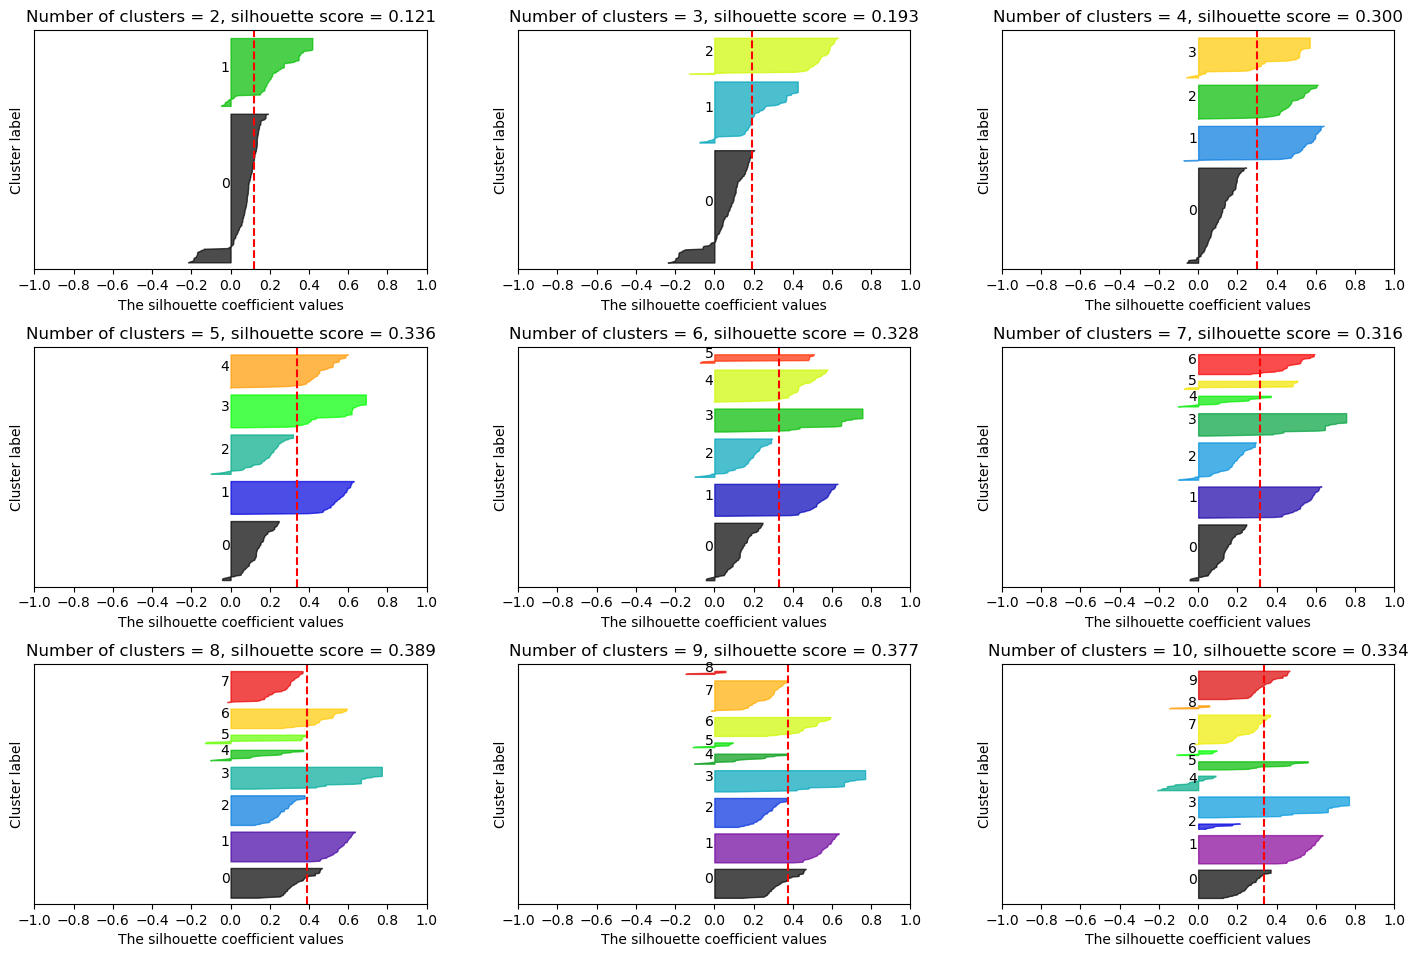

In [18]:
# first group
X = dfDist1.to_numpy()
param = {'X' : X}
plotSilhouetteScore(range_n_clusters, X, KMedoid, param, 'precomputed')

Le graphique pour le groupe 1 montre que le nombre optimal de clusters est de 5. En effet, pour $k = 5$, on obtient un des meilleurs scores moyens et la largeur des clusters est assez homogène, cependant, tous les clusters n'ont pas un score de silhouette supérieur à la ligne rouge. Les autres valeurs de $k$ produisent soit des clusters trop larges ou avec des inconsistances, soit des clusters avec un score de silhouette moyen trop faible.

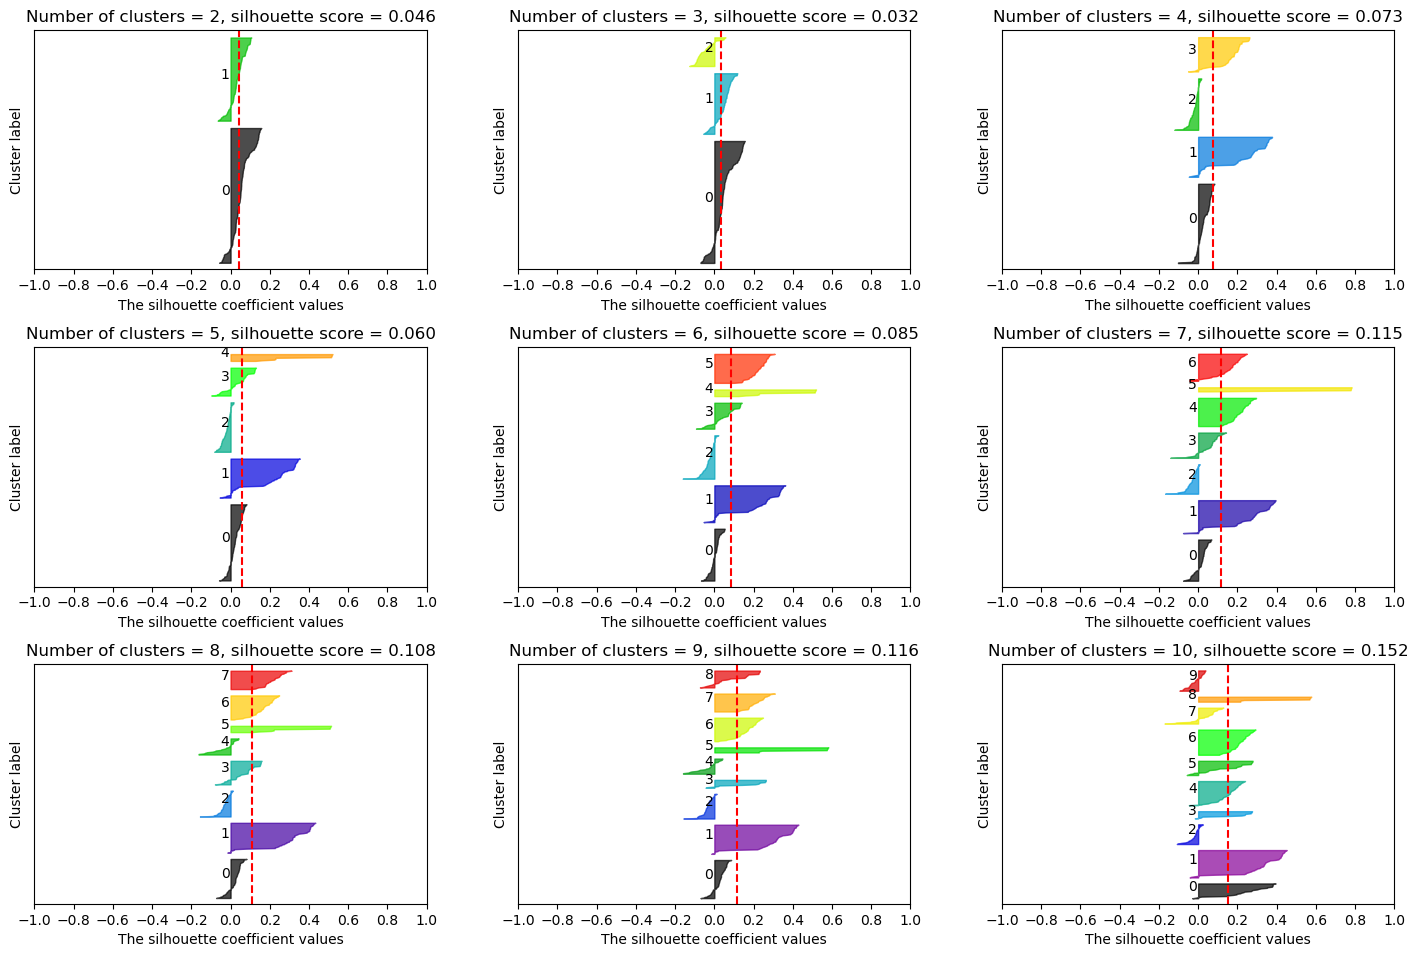

In [19]:
# second group
X = dfDist2.to_numpy()
param = {'X' : X}
plotSilhouetteScore(range_n_clusters, X, KMedoid, param, 'precomputed')

Pour le groupe 2, le graphique montre que le nombre optimal de clusters est de 3. Nous avons moins de points mal classés en comparaison aux autres. Tous les clusters ont un score de silhouette supérieur à la ligne rouge même si on obtient une largeur des clusters très peu homogène. Par ailleurs, 2 ou 4 pourraient aussi être un nombre de clusters envisageable.

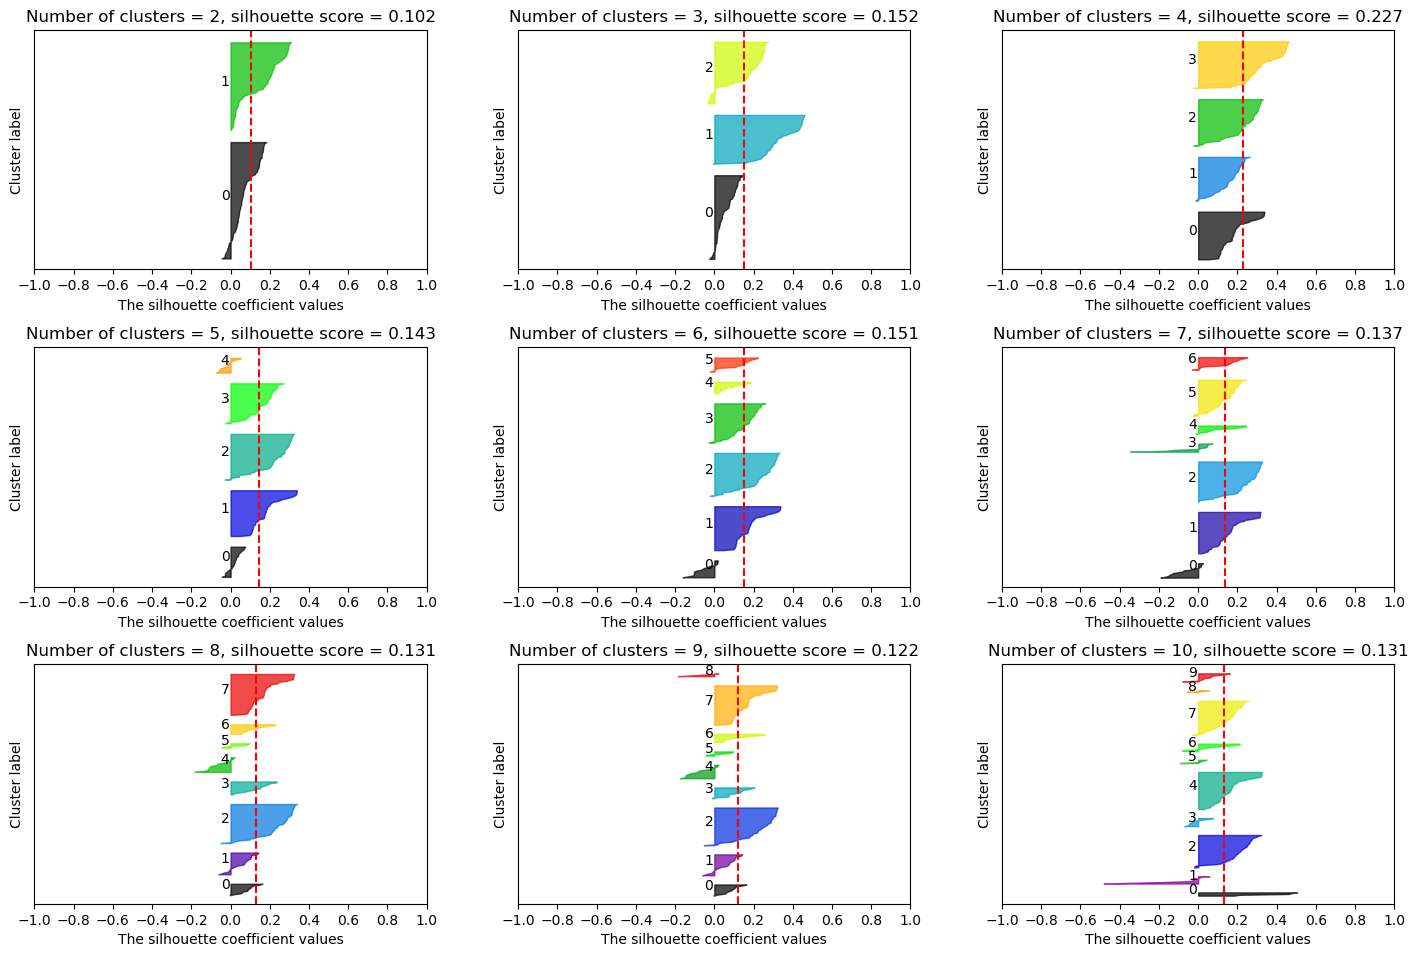

In [20]:
# third group
X = dfDist3.to_numpy()
param = {'X' : X}
plotSilhouetteScore(range_n_clusters, X, KMedoid, param, 'precomputed')

Pour le groupe 3, le graphique montre que le nombre optimal de clusters est 4. On obtient le meilleur score et tous les clusters ont un score de silhouette supérieur à la ligne rouge et la largeur des clusters est assez homogène. 

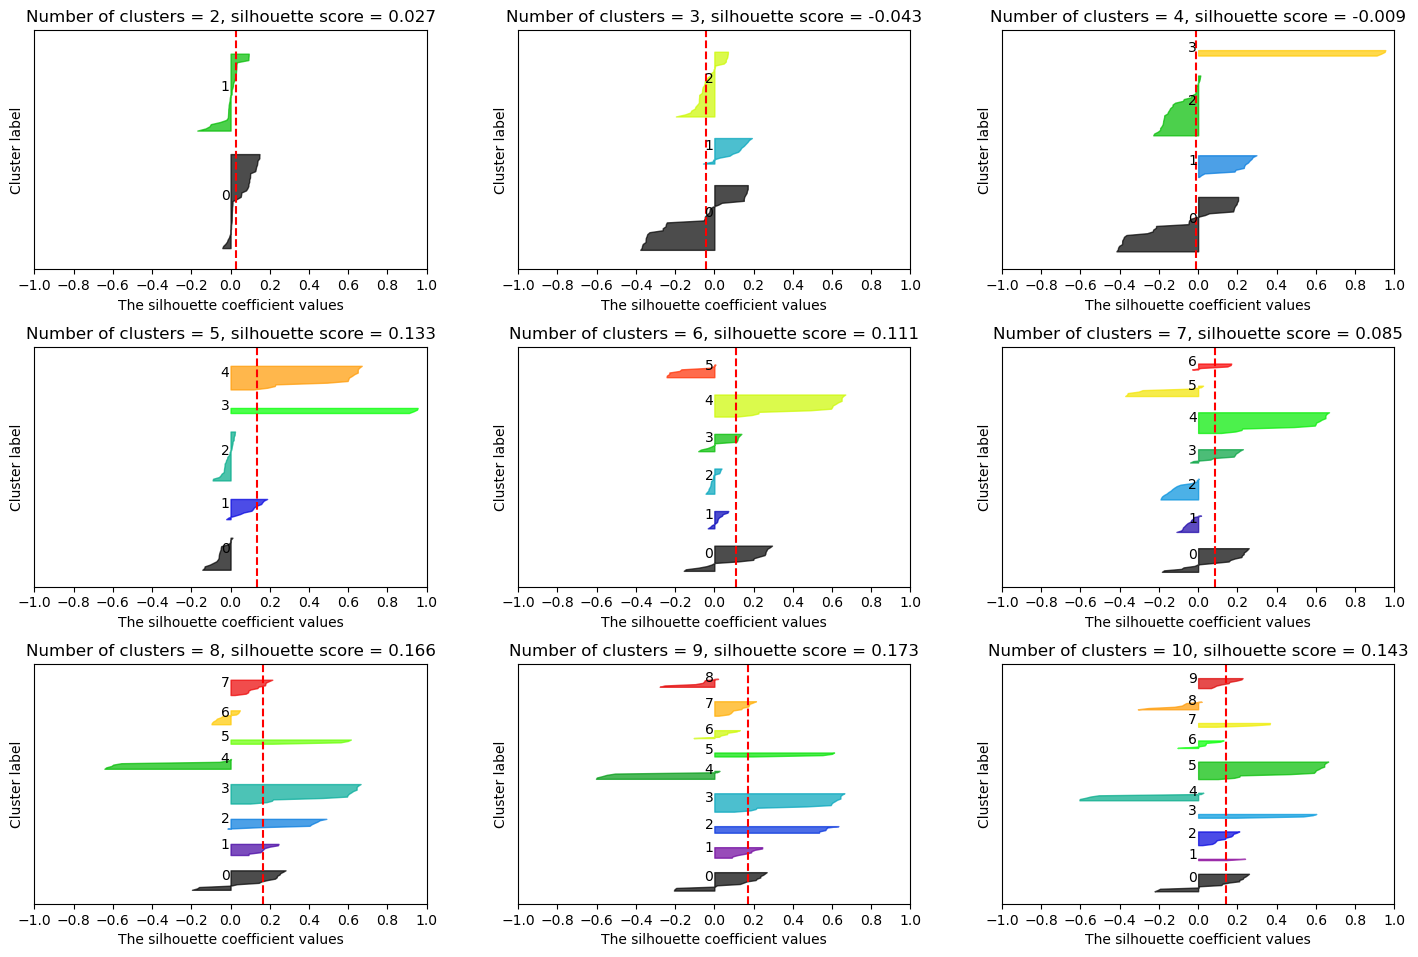

In [21]:
# forth group
X = dfDist4.to_numpy()
param = {'X' : X}
plotSilhouetteScore(range_n_clusters, X, KMedoid, param, 'precomputed')

Pour le groupe 4, le graphique montre que le nombre optimal de clusters est 2. Tous les clusters ont un score de silhouette supérieur à la ligne rouge. Les autres valeurs de $k$ produisent soit des clusters trop larges et peu homogènes et/ou avec un score moyen négatif.

Pour conséquent, le nombre de clusters pour chaque groupe est : 
- Groupe 1 : 5
- Groupe 2 : 3
- Groupe 3 : 4
- Groupe 4 : 2

## 4. Analyse de la signification sémantique
### a) K-Means

In [22]:
# for each clusters, plot its number of k-mers 
def displayClusteringMetrics(n_clusters, df, m, X, KMethod, KMethodParam, sklearn = False):
    # get labels from the specified KMethod
    if sklearn:
        cluster_labels = KMethod(n_clusters = n_clusters, **KMethodParam).fit(X).labels_
    else:
        cluster_labels = KMethod(n_clusters = n_clusters, **KMethodParam)
    
    # add clusters
    m['Cluster'] = cluster_labels
    df['Cluster'] = cluster_labels
    # group by cluster then sum motifs
    m = m.groupby(['Cluster']).sum().transpose()
    # get mean, median and std of the length
    mean = df['sequence'].str.len().groupby(df['Cluster'].values).mean()
    median = df['sequence'].str.len().groupby(df['Cluster'].values).median()
    std = df['sequence'].str.len().groupby(df['Cluster'].values).std()
    stats = pd.concat([mean.to_frame(), median.to_frame(), std.to_frame()], axis=1)
    stats.columns = ['Mean', 'Median', 'Std']
   
    # display
    for cluster in m:
        print('Cluster = {}'.format(cluster))
        sort = m[cluster].sort_values(ascending=False)
        seq = pd.DataFrame(sort.values, index=sort.index).transpose()
        st = stats.iloc[cluster,:].to_frame().transpose()
        st.index = [0]
        kmer = seq.transpose()
        kmer['kmer'] = seq.columns.str.len()
        kmer = kmer.groupby('kmer').sum().transpose()
        kmer.columns = ["{}-mer".format(i) for i in kmer]
        dfMetrics = pd.concat([seq.iloc[:,0:5], st, kmer], axis=1)
        display(dfMetrics)

In [23]:
# KMeans param
param = {'n_init' : 10, 'max_iter' : 1000, 'random_state' : 0}

In [24]:
# first group
displayClusteringMetrics(6, df1.copy(), m1.copy(), m1.to_numpy(), KMeans, param, sklearn=True)

Cluster = 0


,CG,CC,GC,GG,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,363.0,349.0,334.0,331.0,273.0,63.346154,60.0,13.110218,3242.0,3190.0,410.0


Cluster = 1


,AU,CA,AA,UA,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,318.0,310.0,304.0,291.0,278.0,62.203704,61.0,8.548154,3305.0,3251.0,863.0


Cluster = 2


,AA,GC,AU,CG,UA,Mean,Median,Std,2-mer,3-mer,4-mer
0,404.0,287.0,278.0,263.0,251.0,61.055556,62.0,1.43299,3243.0,3189.0,763.0


Cluster = 3


,AG,GC,CA,GU,CG,Mean,Median,Std,2-mer,3-mer,4-mer
0,256.0,253.0,212.0,206.0,200.0,57.847826,54.5,6.937715,2615.0,2569.0,564.0


Cluster = 4


,AA,AAA,GA,UU,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,637.0,389.0,255.0,245.0,240.0,60.32,60.0,2.307397,2966.0,2916.0,771.0


Cluster = 5


,GG,CA,UC,GA,CG,Mean,Median,Std,2-mer,3-mer,4-mer
0,328.0,243.0,230.0,218.0,215.0,61.040816,59.0,7.945017,2942.0,2893.0,422.0


Le __cluster 0__ a une fréquence élevée de CG, CC, GC et GG. 
</br>Le __cluster 1__ a une fréquence élevée de AU, CA, AA et UA. 
</br>Le __cluster 2__ a une fréquence élevée de AA et GC, mais le motif AA semble être plus fréquent que les autres motifs. 
</br>Le __cluster 3__ a une fréquence élevée de AG et GC. 
</br>Le __cluster 4__ a une fréquence élevée de AA et AAA. Ici aussi le motif AA est bien plus fréquent que les autres motifs. Il y a un forte fréquence du motif AAA qui est le seul 3-mers présent parmi les motifs les plus fréquents.
</br>Le __cluster 5__ a une fréquence élevée de GG et CA. 

On retrouve plusieurs motifs qui sont partagés entre les clusters comme CG qui est présent parmi les motifs les plus présents dans les __clusters 0, 2, 3 et 5__. Ou alors les clusters AA et GC.

La plupart des clusters ont une moyenne et médiane autour de 60. C'est moins le cas pour le __cluster 3__ qui est un petit peu inférieur. 
Le __cluster 0__ a une déviation standard relativement plus élevée que les autres, ce qui suggère une distribution plus étalée que les autres clusters. Les autres clusters ont des déviations standards plus faibles, ce qui suggère des distributions plus resserrées.

Tous les clusters ont une fréquence des 2-mers, 3-mers bien plus élevée que les 4-mers.

In [25]:
# second group
displayClusteringMetrics(3, df2.copy(), m2.copy(), m2.to_numpy(), KMeans, param, sklearn=True)

Cluster = 0


,GG,CC,GC,CG,GA,Mean,Median,Std,2-mer,3-mer,4-mer
0,2304.0,2127.0,2013.0,1899.0,1708.0,216.714286,206.0,31.458661,24156.0,24042.0,23259.0


Cluster = 1


,UU,UG,AU,CU,UC,Mean,Median,Std,2-mer,3-mer,4-mer
0,1765.0,1647.0,1512.0,1434.0,1400.0,211.726316,201.0,30.095395,20014.0,19917.0,19443.0


Cluster = 2


,AA,UA,AG,UG,GU,Mean,Median,Std,2-mer,3-mer,4-mer
0,2750.0,1692.0,1690.0,1676.0,1586.0,193.441667,190.0,26.667828,23091.0,22970.0,22412.0


Le __cluster 0__ a une fréquence élevée des k-mers GG, CC, GC, CG, GA.
</br>Le __cluster 1__ a une fréquence élevée des k-mers UU, UG, AU, CU, UC. 
</br>Le __cluster 2__ a une fréquence élevée des k-mers AA, UA, AG, UG, GU.  

La moyenne de 216 et la médiane à 206 du __cluster 0__ sont les plus élevées parmi les trois clusters, ce qui indique que les séquences dans ce cluster sont les plus similaires les unes aux autres. La déviation standard est également élevée, ce qui suggère que les séquences peuvent avoir des variations significatives malgré leur similitude. La déviation standard du __cluster 2__ est la plus basse des trois clusters, ce qui suggère que les séquences dans ce cluster sont relativement homogènes.

Pour chaque cluster, la fréquence des 2-mers, 3-mers et 4-mers est élevée, mais la fréquence des 4-mers est également la plus basse des trois.

In [26]:
# third group
displayClusteringMetrics(2, df3.copy(), m3.copy(), m3.to_numpy(), KMeans, param, sklearn=True)

Cluster = 0


,GG,GC,CG,CC,AA,Mean,Median,Std,2-mer,3-mer,4-mer
0,4338.0,3675.0,3540.0,3221.0,2947.0,362.448276,362.0,20.065694,41924.0,41807.0,41669.0


Cluster = 1


,AA,AG,UU,UA,GA,Mean,Median,Std,2-mer,3-mer,4-mer
0,2688.0,1952.0,1847.0,1846.0,1827.0,356.214286,364.0,24.442712,24863.0,24793.0,24678.0


Le __cluster 0__ a une fréquence élevée des k-mers GC, CG, CC, AA. Les 2-mers et 3-mers ont également des fréquences élevées. En comparaison avec le deuxième cluster, les fréquences de k-mer sont plus élevées, mais à part AA, il n'y a pas de k-mer avec une fréquence élevée qui est partagé entre les deux clusters.
</br>Le __cluster 1__ a une fréquence élevée des k-mers AA, AG, UU, UA.

Les deux clusters ont une moyenne similaire, mais que le __cluster 0__ a une plus faible déviation standard que le __cluster 1__.

In [27]:
# fourth group
displayClusteringMetrics(4, df4.copy(), m4.copy(), m4.to_numpy(), KMeans, param, sklearn=True)

Cluster = 0


,AC,GG,CC,CU,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,2122.0,1914.0,1852.0,1797.0,1632.0,460.078431,461.0,7.036599,23413.0,23362.0,23232.0


Cluster = 1


,GG,UU,UG,GU,UC,Mean,Median,Std,2-mer,3-mer,4-mer
0,875.0,661.0,633.0,629.0,590.0,507.4375,522.0,31.832832,8103.0,8087.0,7983.0


Cluster = 2


,GG,GC,CG,CC,AG,Mean,Median,Std,2-mer,3-mer,4-mer
0,499.0,429.0,422.0,343.0,312.0,425.7,417.5,16.19362,4247.0,4237.0,4186.0


Cluster = 3


,AA,UA,UU,AU,GU,Mean,Median,Std,2-mer,3-mer,4-mer
0,282.0,246.0,233.0,199.0,157.0,510.0,509.0,4.123106,2545.0,2540.0,2438.0


Le __cluster 0__ est composé principalement des k-mers AC, GG, CC, CU et UG. 
</br>Le __cluster 1__ est composé principalement des k-mers GG, UU, UG, GU et UC. La distribution est assez large, avec une déviation standard de 31.832832.
</br>Le __cluster 2__ est composé principalement des k-mers GG, GC, CG, CC et AG. La distribution est relativement serrée, avec une déviation standard de 16.19362.
</br>Le __cluster 3__ est composé principalement des k-mers AA, UA, UU, AU et GU. 

Les écarts-types sont assez faibles pour les __clusters 0 et 3__. Cependant, la moyenne varie considérablement entre les groupes, ce qui suggère des niveaux différents d'homogénéité dans les séquences et les fréquences de k-mers.

Les clusters ont des fréquences de 2-mers, 3-mers et 4-mers similaires, mais celle du __cluster 0__ est bien plus élevée que les autres. D'un cluster à l'autre, la fréquence semble beaucoup diminuer (divisé par 2).

In [28]:
# first group
X = dfDist1.to_numpy()
param = {'X' : X}
displayClusteringMetrics(5, df1.copy(), m1.copy(), X, KMedoid, param)

Cluster = 0


,GG,CG,CC,GC,UC,Mean,Median,Std,2-mer,3-mer,4-mer
0,584.0,525.0,478.0,459.0,416.0,61.604396,60.0,10.362195,5515.0,5424.0,754.0


Cluster = 1


,AU,AA,CA,UA,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,296.0,292.0,289.0,273.0,252.0,61.019608,61.0,0.140028,3061.0,3010.0,820.0


Cluster = 2


,AG,GC,CA,GG,CG,Mean,Median,Std,2-mer,3-mer,4-mer
0,321.0,308.0,279.0,266.0,264.0,59.245902,58.0,7.934431,3553.0,3492.0,722.0


Cluster = 3


,AA,AU,GC,CG,UA,Mean,Median,Std,2-mer,3-mer,4-mer
0,371.0,277.0,273.0,254.0,241.0,61.705882,62.0,4.965054,3096.0,3045.0,715.0


Cluster = 4


,AA,AAA,GA,UG,UU,Mean,Median,Std,2-mer,3-mer,4-mer
0,642.0,389.0,262.0,252.0,249.0,61.54902,60.0,9.069319,3088.0,3037.0,782.0


- __Cluster 0__ : Pour reconstruire une séquence représentative, nous allons utiliser les informations fournies par les k-mers les plus fréquents, ainsi que leur fréquence respective. Dans ce cas, les 2-mers les plus fréquents sont GG, CG, CC, GC et UC. Nous allons donc utiliser ces 2-mers pour reconstruire notre séquence représentative.

Commençons par le premier k-mer le plus fréquent : GG. Nous allons le placer au début de notre séquence représentative. Ensuite, nous allons chercher le k-mer suivant le plus fréquent qui se chevauche avec le premier, c'est à dire qui commence par la dernière base de la séquence représentative actuelle, donc GC. Nous allons placer GCC car elle chevauche avec CCG. Nous continuons ainsi avec les k-mers les plus fréquents jusqu'à ce que nous ayons atteint la longueur souhaitée pour notre séquence représentative.

On continue le processus en cherchant le k-mer le plus fréquent qui commence par la dernière base de la séquence représentative actuelle. Dans ce cas-ci, la dernière base est "G", et le k-mer le plus fréquent qui commence par "G" est "GC". On ajoute donc "GC" à la fin de la séquence représentative. On ajoute donc "GC" à la fin de la séquence représentative. Puis on répète l'étape.

Voici un exemple de séquence représentative pour ce cluster : "GGCCGUC"


- __Cluster__ 1 : De même ici, les 2-mers les plus fréquent dans ce cluster sont "AU" suivis de "AA" puis "CA", "UA" et "UG". Par conséquent, nous pouvons choisir une séquence qui contient fréquemment ces 5 marqueurs en faisant des chevauchements, telle que "AUAACAUAUG".

- __Cluster__ 2 : La séquence représentative pourrait être "AGCAGGCG".

- __Cluster__ 3 : La séquence représentative pourrait être "AAUAGCG".

- __Cluster__ 4 : La séquence représentative pourrait être "AAAGAUGUU".

In [29]:
# second group
X = dfDist2.to_numpy()
param = {'X' : X}
displayClusteringMetrics(3, df2.copy(), m2.copy(), X, KMedoid, param)

Cluster = 0


,GG,UG,GA,AG,CC,Mean,Median,Std,2-mer,3-mer,4-mer
0,3020.0,2936.0,2685.0,2633.0,2580.0,204.484043,201.0,24.279451,38248.0,38057.0,37048.0


Cluster = 1


,AA,UG,AG,GA,GG,Mean,Median,Std,2-mer,3-mer,4-mer
0,1971.0,1364.0,1335.0,1299.0,1254.0,203.223404,201.0,32.155253,19005.0,18909.0,18398.0


Cluster = 2


,AA,GG,UG,GC,AG,Mean,Median,Std,2-mer,3-mer,4-mer
0,966.0,724.0,720.0,707.0,630.0,223.4,212.0,46.058954,10008.0,9963.0,9668.0


- __Cluster 0__ : La séquence représentative pourrait être "GGUGAGCC".

- __Cluster 1__ : La séquence représentative pourrait être "AAGAUGG".

- __Cluster 2__ : La séquence représentative pourrait être "AAGGCUGAG".

In [30]:
# third group
X = dfDist3.to_numpy()
param = {'X' : X}
displayClusteringMetrics(4, df3.copy(), m3.copy(), X, KMedoid, param)

Cluster = 0


,AA,GG,GC,CG,AG,Mean,Median,Std,2-mer,3-mer,4-mer
0,1390.0,1379.0,1367.0,1304.0,1134.0,358.958333,363.0,19.891149,17180.0,17132.0,17073.0


Cluster = 1


,GG,GC,AG,CC,CG,Mean,Median,Std,2-mer,3-mer,4-mer
0,1783.0,1392.0,1364.0,1242.0,1212.0,364.590909,360.5,26.162567,15998.0,15954.0,15899.0


Cluster = 2


,GG,CG,GC,AA,CC,Mean,Median,Std,2-mer,3-mer,4-mer
0,1639.0,1372.0,1365.0,1219.0,1195.0,351.957447,354.0,17.381846,16491.0,16443.0,16378.0


Cluster = 3


,AA,AG,GA,UG,UA,Mean,Median,Std,2-mer,3-mer,4-mer
0,1875.0,1379.0,1367.0,1247.0,1224.0,365.212766,369.0,21.870107,17118.0,17071.0,16997.0


- __Cluster 0__ : La séquence représentative pourrait être "AAGGCGAG".

- __Cluster 1__ : La séquence représentative pourrait être "GGCAGCCCG".

- __Cluster 2__ : La séquence représentative pourrait être "GGCGCCAA".

- __Cluster 3__ : La séquence représentative pourrait être "AAGAUGUA".

In [32]:
# fourth group
X = dfDist4.to_numpy()
param = {'X' : X}
displayClusteringMetrics(2, df4.copy(), m4.copy(), X, KMedoid, param)

Cluster = 0


,GG,CC,AC,CU,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,2008.0,1599.0,1503.0,1474.0,1450.0,470.288889,461.0,31.17591,21118.0,21073.0,20912.0


Cluster = 1


,GG,AC,AA,CC,UG,Mean,Median,Std,2-mer,3-mer,4-mer
0,1424.0,1286.0,1264.0,1235.0,1158.0,465.594595,461.0,29.668033,17190.0,17153.0,16927.0


Cluster 0 : La séquence représentative pourrait être "GGCCACUG".

Cluster 1 : La séquence représentative pourrait être "GGACAACCUG".

### c) Comparaison entre les deux méthodes

La méthode KMedoid avec les matrices de distances permet une analyse plus approfondie de la signification sémantique des clusters que la méthode KMeans par la représentation vectorielle. En effet, la méthode KMedoid cherche à minimiser les distances entre les points du cluster. Ainsi, les clusters sont formés en regroupant les points les plus similaires entre eux. Elle se base sur les distances au centre du cluster qui est représenté par l'un des points du cluster, et non pas sur une moyenne comme dans la méthode KMeans. C'est la raison pour laquelle cette méthode est plus robuste aux outliers que K-moyennes.

De plus, la matrice de distance utilisée dans la méthode KMedoid prend en compte les différences entre les séquences d'ARN, ce qui est plus adapté à ce problème que la distance euclidienne utilisée dans la représentation vectorielle car elle ne prend pas directement en compte les similarités et les différences entre les données elles-mêmes.